# 0 - Export Elevation surface

Export the topography from SRTM to the local projection (GDA94 MGA55) at 5km resolution

In [26]:
import pycurious
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import h5py
import netCDF4

%matplotlib inline

In [2]:
elevation_file = "/home/ben/Dropbox/USyd/data/bathymetry_e140s10.nc"

with netCDF4.Dataset(elevation_file, "r") as cdf:
    lon = cdf.variables['x'][:].copy()
    lat = cdf.variables['y'][:].copy()
    val = cdf.variables['z'][:].copy()

In [3]:
lonq, latq = np.meshgrid(lon,lat)

x, y = pycurious.mapping.transform_coordinates(lonq.ravel(), latq.ravel(), epsg_in=4326, epsg_out=28355)

/usr/lib/python3.7/site-packages/pyproj/crs/crs.py:279: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/usr/lib/python3.7/site-packages/pyproj/crs/crs.py:279: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [4]:
extent_local = [447374.524, 1238206.595, 5993315.448, 7899172.548]
xmin,xmax,ymin,ymax = extent_local

nx, ny = int(round((xmax - xmin)/1e3)), int(round((ymax - ymin)/1e3))
xq, yq = np.meshgrid(np.linspace(xmin, xmax, nx),
                     np.linspace(ymin, ymax, ny))

z_grid = pycurious.mapping.grid(np.c_[x,y], val.ravel(), extent_local, (ny,nx))

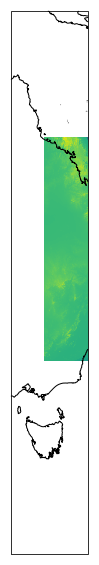

In [5]:
proj = ccrs.epsg(28355)


fig = plt.figure(figsize=(10,10))

ax = plt.axes(projection=proj)
ax.imshow(z_grid, extent=extent_local, transform=proj)
ax.coastlines(resolution='10m')

In [8]:
np.savetxt("../Data/00_Elevation_1km.csv",
           np.c_[xq.ravel(),yq.ravel(),z_grid.ravel()],
           delimiter=',',
           fmt='%.3f',
           header='eastings,northings,RL')

## Export recharge data

In [7]:
recharge_file = "../Data/recharge_Crosbie2018/"

RK_05, extent_05 = pycurious.mapping.import_geotiff("../Data/recharge_Crosbie2018/RK_05.tif")
RK_50, extent_50 = pycurious.mapping.import_geotiff("../Data/recharge_Crosbie2018/RK_50.tif")
RK_95, extent_95 = pycurious.mapping.import_geotiff("../Data/recharge_Crosbie2018/RK_95.tif")

PROJCS["GDA94 / MGA zone 55",
    GEOGCS["GDA94",
        DATUM["Geocentric_Datum_of_Australia_1994",
            SPHEROID["GRS 1980",6378137,298.257222101,
                AUTHORITY["EPSG","7019"]],
            AUTHORITY["EPSG","6283"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4283"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",147],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",10000000],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","28355"]]
PROJCS["GDA94 / MGA zone 55",
    GEOGCS["GDA94",
        DATUM["Geocentric_Datum_of_Australia_1994",
            SPHEROID["GRS 1980",6378137,298.257222101,
                AUTHORITY["EPSG","7019"]],


In [19]:
RK_05[RK_05==RK_05.min()] = np.nan
RK_50[RK_50==RK_50.min()] = np.nan
RK_95[RK_95==RK_95.min()] = np.nan

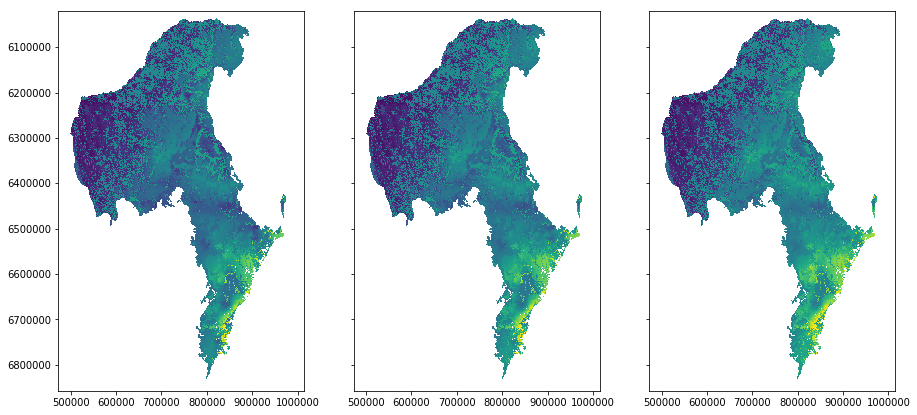

In [21]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, sharey=True, figsize=(15,10))

im1 = ax1.imshow(np.log10(RK_05), extent=extent_05)
im2 = ax2.imshow(np.log10(RK_50), extent=extent_50)
im2 = ax3.imshow(np.log10(RK_95), extent=extent_95)


In [22]:
# assume 50th percentile is the mean
RK_mean = RK_50

# 5th and 95th percentiles are 2 stds from the mean
RK_std = (RK_95 - RK_05)/4

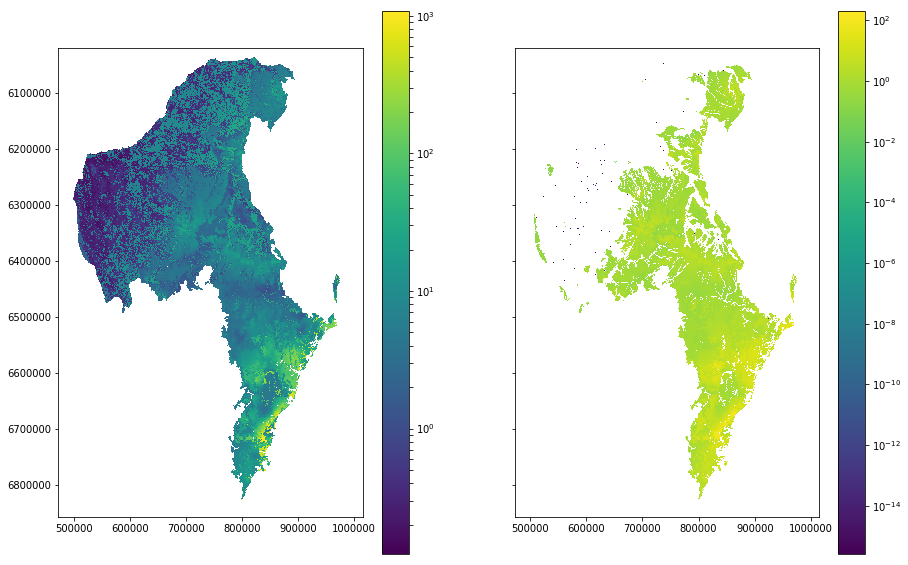

In [28]:
fig, (ax1,ax2) = plt.subplots(1,2, sharey=True, figsize=(15,10))

im1 = ax1.imshow(RK_mean, extent=extent_05, norm=mcolors.LogNorm())
im2 = ax2.imshow(RK_std,  extent=extent_50, norm=mcolors.LogNorm())

fig.colorbar(im1, ax=ax1, )
fig.colorbar(im2, ax=ax2)

In [37]:
print("Min recharge: {:.2f} mm/yr".format(np.nanmin(RK_mean)))
print("Max recharge: {:.2f} mm/yr".format(np.nanmax(RK_mean)))

Min recharge: 0.12 mm/yr
Max recharge: 1091.00 mm/yr


In [45]:
np.nanmax(RK_mean)/1000/365 # m/day

0.002989041095890411

In [31]:
# extract data where we have it

xcoords = np.linspace(extent_50[0], extent_50[1], RK_50.shape[1])
ycoords = np.linspace(extent_50[2], extent_50[3], RK_50.shape[0])
xq, yq = np.meshgrid(xcoords,ycoords)


RK_mask = np.isfinite(RK_mean)
RK_mean_flat = RK_mean[RK_mask]
RK_std_flat  = RK_std[RK_mask]
RK_eastings  = xq[RK_mask]
RK_northings = yq[RK_mask]

In [35]:
# save to text file

np.savetxt("../Data/recharge_Crosbie2018.csv",
           np.c_[RK_eastings, RK_northings, RK_mean_flat, RK_std_flat],
           header='eastings (GDA94 MGA55), northings (GDA94 MGA55), mean (mm/yr), std (mm/yr)',
           delimiter=',', fmt='%.4f,%.4f,%.1f,%.1f')